In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

# MDN

In [2]:
coord_path = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\coordinates_mdn_224")
coord_path = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\non_white_coordinates_mdn_224")

In [3]:
summ_df = pd.read_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\mdn_summary_vst.csv")

In [4]:
summ_df.tail(2)

,patient_ID,sample_ID,ID_Nucleic_Acid,ID_scan,histological_aspect,sous_type_visuel,stroma_visual_aspect,path_svs,path_xml,IMMU_Tcellatlas_CD4.CD8_c4_Tstr,...,PDAC_CSY20_Sig9,PDAC_CSY20_Sig12,Exocrine,Endocrine,Classic,StromaActiv,Basal,StromaActivInflam,Immune,StromaInactive
403,BPDAC_101,BPDAC_101_21_L2,X0423_022,14AG03394-21_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.312502,...,-0.223764,-0.233952,-0.878966,-0.461685,-2.463755,0.716643,1.948524,0.711195,-1.028648,-1.442472
404,BPDAC_101,BPDAC_101_21_L3,X0423_023,14AG03394-21_MDNF01_HES,non_gland_forming,NaN,NaN,C:\Users\inserm\Documents\histo_sign\dataset\M...,C:\Users\inserm\Documents\histo_sign\dataset\M...,-0.333591,...,-0.297224,-0.220698,-0.695461,-0.769956,-2.293382,0.861645,0.921496,0.304906,1.002893,-0.384292


## Number of tiles

In [5]:
def get_n_tiles(sample_id):
    n_tiles = np.load(coord_path / sample_id / "tiles_coord.npy").shape[0]
    return n_tiles


# summ_df["n_tiles"] = summ_df.sample_ID.apply(get_n_tiles)
summ_df["n_tiles"] = summ_df.ID_scan.apply(get_n_tiles)

In [6]:
print(f"Total number of tiles: {summ_df['n_tiles'].sum()}")

Total number of tiles: 11932176


In [7]:
summ_df.groupby(by="patient_ID").n_tiles.mean()

patient_ID
BPDAC_001    33476.750000
BPDAC_002    40935.666667
BPDAC_003    26950.000000
BPDAC_004    25696.000000
BPDAC_005    26953.333333
                 ...     
BPDAC_097    19598.500000
BPDAC_098    26267.333333
BPDAC_099    38150.000000
BPDAC_100    28913.666667
BPDAC_101    19708.750000
Name: n_tiles, Length: 95, dtype: float64

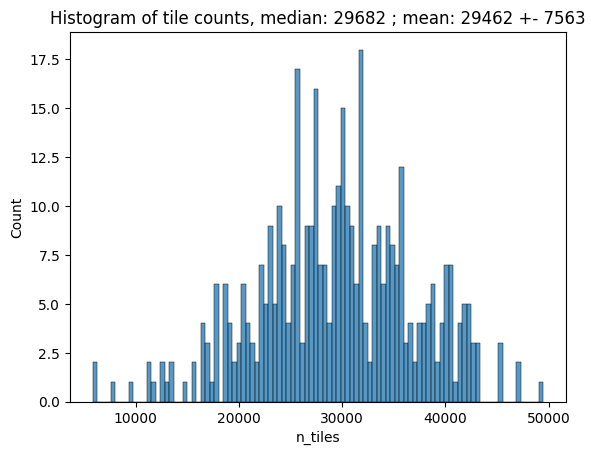

In [8]:
sns.histplot(summ_df["n_tiles"], bins=100)
plt.title(
    "Histogram of tile counts, median: {:.0f} ; mean: {:.0f} +- {:.0f}".format(
        np.median(summ_df["n_tiles"]), np.mean(summ_df["n_tiles"]), np.std(summ_df["n_tiles"])
    )
)
plt.show()

In [9]:
print(
    f" {summ_df.shape[0]} rows, {summ_df.sample_ID.nunique()} samples, {summ_df.patient_ID.nunique()} patients, {summ_df.ID_scan.nunique()} scans"
)

 405 rows, 405 samples, 95 patients, 238 scans


## Explore labels

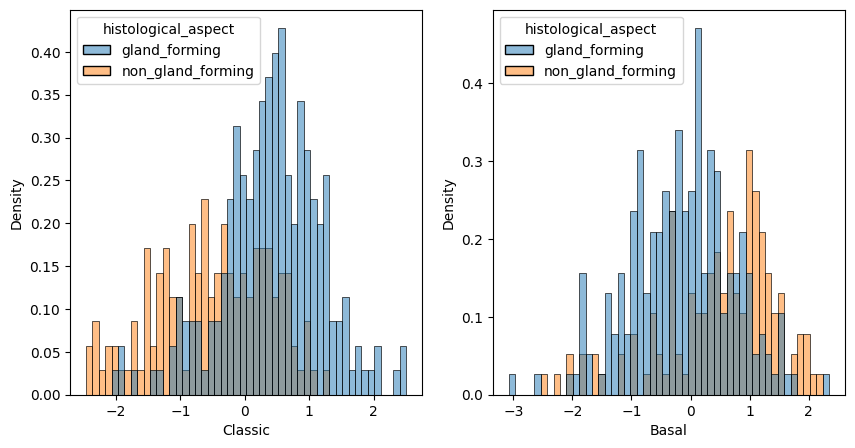

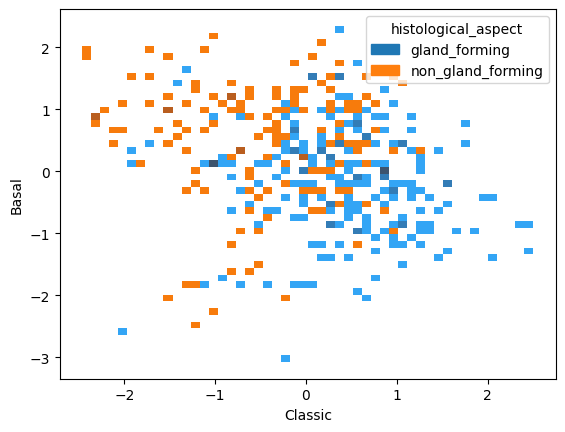

In [10]:
labels = summ_df[["Basal", "Classic", "histological_aspect"]]
labels = labels[labels["histological_aspect"].isin(["gland_forming", "non_gland_forming"])]
# labels[labels.isna().any(axis=1)]
labels = labels.dropna()
# Compute correlation between histological aspect and molecular subtypes
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# labels["histological_aspect"] = le.fit_transform(labels["histological_aspect"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(labels, x="Classic", hue="histological_aspect", bins=50, ax=ax1, stat="density")
sns.histplot(labels, x="Basal", hue="histological_aspect", bins=50, ax=ax2, stat="density")
plt.show()

# Bivariate histogram
sns.histplot(labels, x="Classic", y="Basal", bins=50, hue="histological_aspect")
plt.show()

<Axes: xlabel='Classic', ylabel='Basal'>

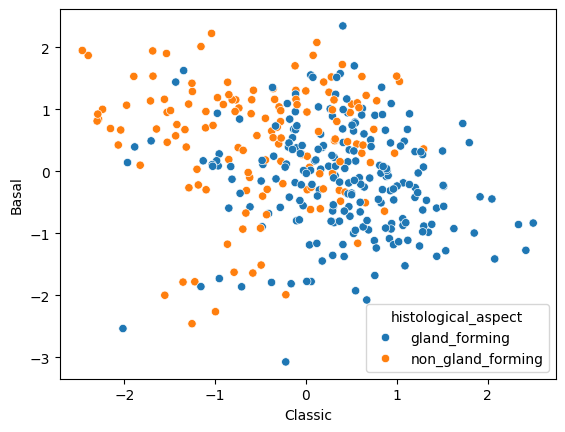

In [11]:
sns.scatterplot(data=labels, x="Classic", y="Basal", hue="histological_aspect")

# Correlation between signatures

In [12]:
# select only signature columns
signatures = summ_df.columns.values[9:-1]
signatures_df = summ_df[signatures]
sign_corr = signatures_df.corr()
print(f"Number of signatures: {len(signatures)}")

Number of signatures: 118


In [13]:
# select max correlation for each signature excluding itself
best_corr = sign_corr.apply(lambda x: x[x != 1].idxmax())
best_corr = pd.DataFrame(best_corr, columns=["best_corr"])
best_corr["value"] = best_corr.apply(lambda x: sign_corr.loc[x.name, x.best_corr], axis=1)
best_corr.sort_values(by="value", ascending=False, inplace=True)
best_corr

,best_corr,value
PDAC_CSY20_Sig5,PDAC_Moffitt15_Endocrine,0.992254
PDAC_Moffitt15_Endocrine,PDAC_CSY20_Sig5,0.992254
CAF_FMG20_Normal.Fibroblast,PDAC_CSY20_Sig5,0.987701
PDAC_Hwang22_Malignstate.CyclingG2M,PDAC_Hwang22_Malignstate.CyclingS,0.985588
PDAC_Hwang22_Malignstate.CyclingS,PDAC_Hwang22_Malignstate.CyclingG2M,0.985588
...,...,...
StromaActivInflam,StromaActiv,0.391490
Endocrine,Classic,0.364963
Classic,Endocrine,0.364963
StromaInactive,StromaActivInflam,0.332259


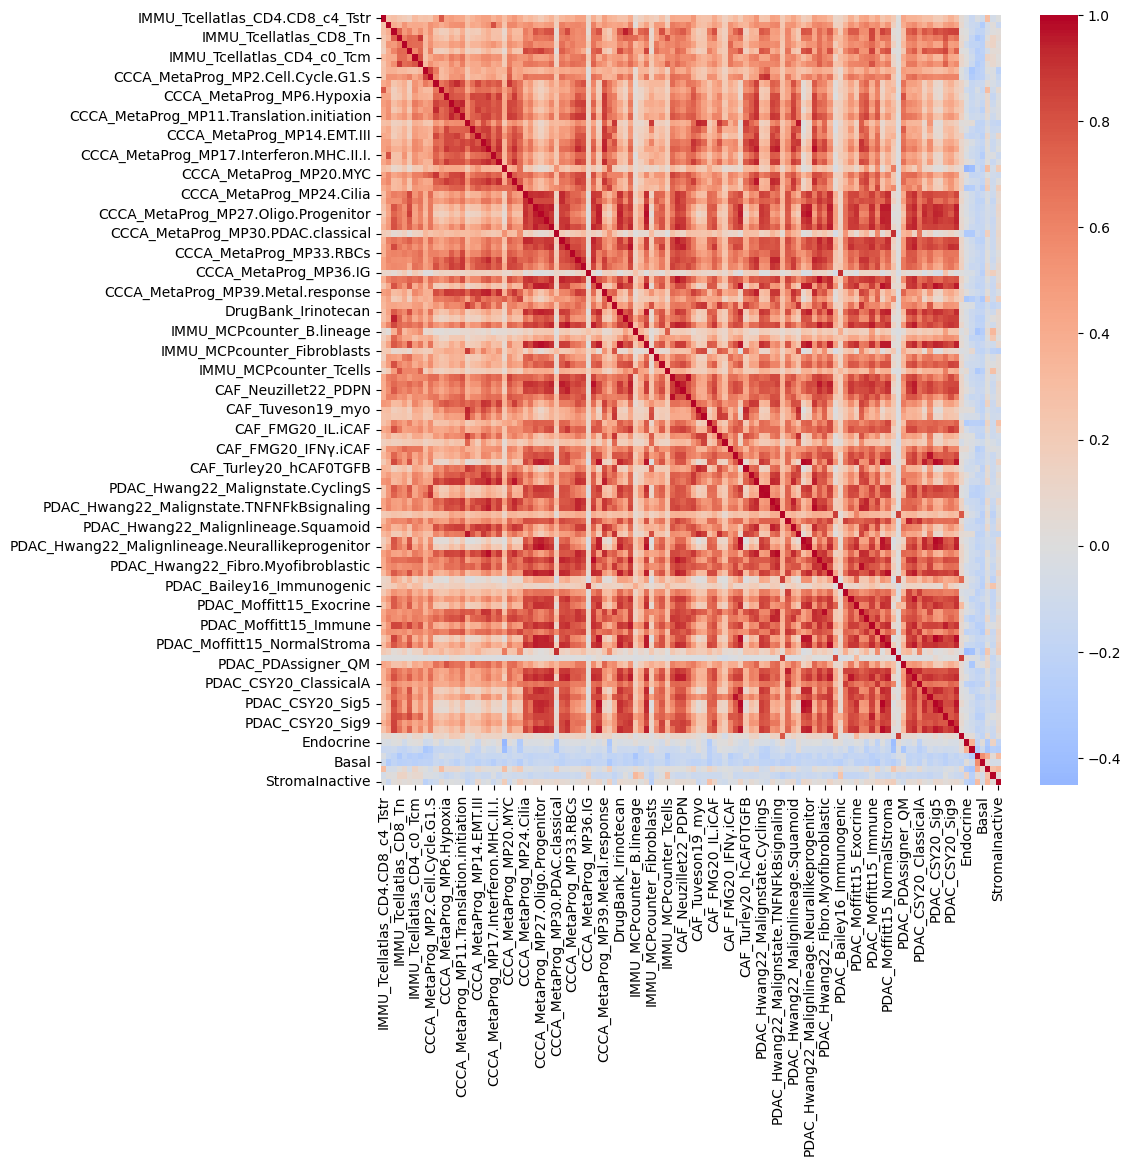

In [14]:
# display correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(sign_corr, annot=False, cmap="coolwarm", center=0)
plt.show()

In [15]:
# Filter signatures so as to keep only those with a correlation below a certain threshold
threshold = 0.8

to_drop = best_corr.iloc[0]
while to_drop.value > threshold:
    best_corr.drop(index=to_drop.best_corr, inplace=True)
    signatures = best_corr.index
    print(f"Dropping {to_drop.best_corr} be cause of correlation {to_drop.value} with {to_drop.name}")

    signatures_df = summ_df[signatures]
    sign_corr = signatures_df.corr()
    best_corr = sign_corr.apply(lambda x: x[x != 1].idxmax())
    best_corr = pd.DataFrame(best_corr, columns=["best_corr"])
    best_corr["value"] = best_corr.apply(lambda x: sign_corr.loc[x.name, x.best_corr], axis=1)
    best_corr.sort_values(by="value", ascending=False, inplace=True)

    to_drop = best_corr.iloc[0]

Dropping PDAC_Moffitt15_Endocrine be cause of correlation 0.9922544534611656 with PDAC_CSY20_Sig5
Dropping CAF_FMG20_Normal.Fibroblast be cause of correlation 0.9877013754549236 with PDAC_CSY20_Sig5
Dropping PDAC_Hwang22_Malignstate.CyclingS be cause of correlation 0.985588045744604 with PDAC_Hwang22_Malignstate.CyclingG2M
Dropping PDAC_Hwang22_Malignstate.TNFNFkBsignaling be cause of correlation 0.9847484808961098 with PDAC_Hwang22_Fibro.Adhesive
Dropping PDAC_Hwang22_Malignlineage.Neuroendocrinelike be cause of correlation 0.9844978871087096 with PDAC_CSY20_Sig5
Dropping PDAC_Moffitt15_ActivatedStroma be cause of correlation 0.9778811163723832 with PDAC_Hwang22_Fibro.Myofibroblastic
Dropping PDAC_Hwang22_Fibro.Neurotropic be cause of correlation 0.9757615386682666 with PDAC_Moffitt15_NormalStroma
Dropping CAF_Neuzillet22_subPOSTN be cause of correlation 0.9748833905415487 with CAF_Neuzillet22_POSTN
Dropping PDAC_Hwang22_Fibro.Adhesive be cause of correlation 0.9730511184092321 with C

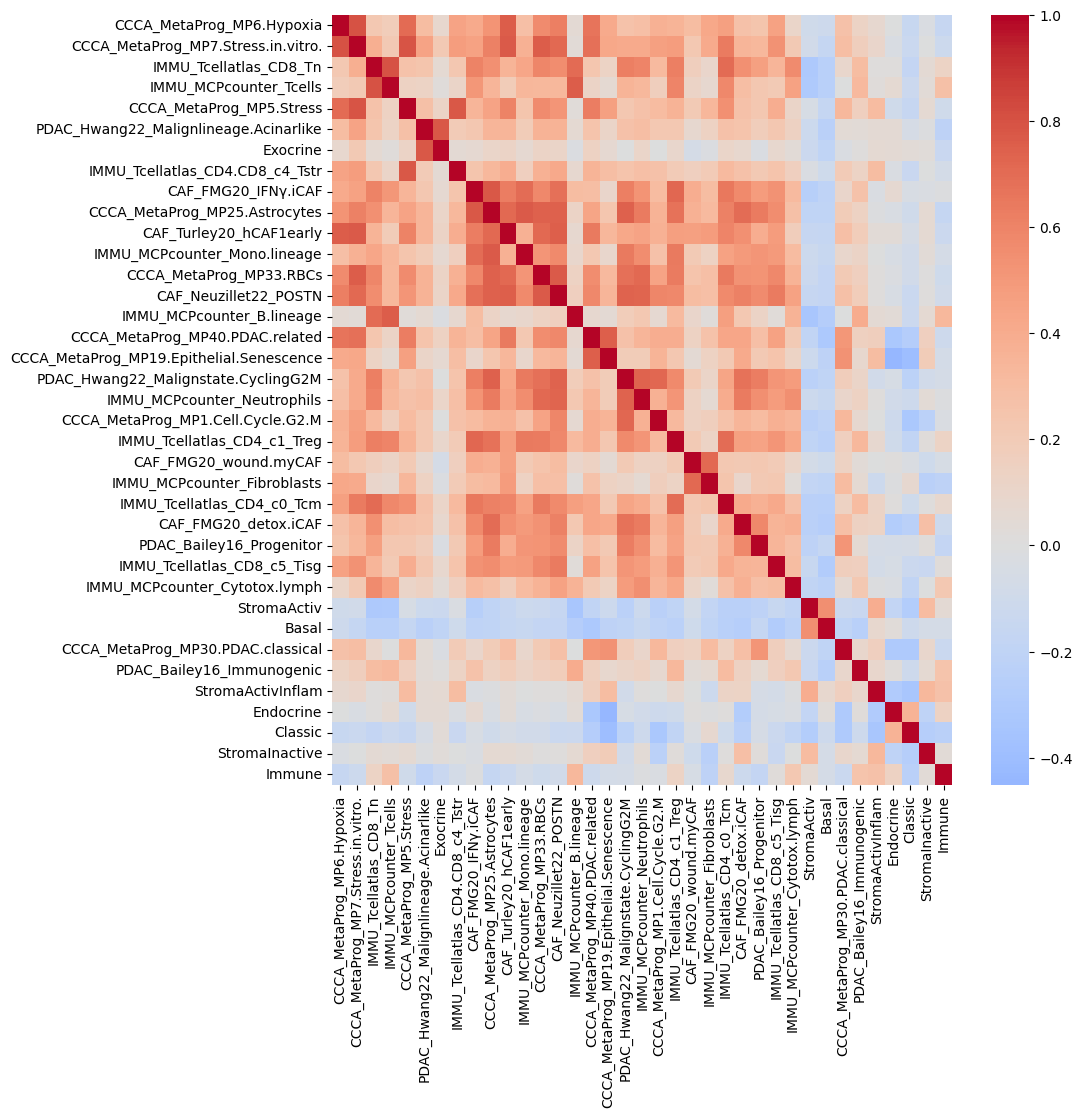

In [16]:
# display correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(sign_corr, annot=False, cmap="coolwarm", center=0)
plt.show()

# PancMulticentric

In [17]:
summ_df = pd.read_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\panc_summary_vst.csv")
path_annot = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\coordinates_panc_224")

In [18]:
row = summ_df.iloc[0]


def get_tiles_info(row):
    sample_ID = row.sample_ID
    try:
        coords = np.load(path_annot / row.sample_ID / "tiles_coord.npy")
        n_tiles = coords.shape[0]
        n_tum_tiles = int(coords[:, -1].sum())
    except FileNotFoundError:
        n_tiles = np.nan
        n_tum_tiles = np.nan
    return {"n_tiles": n_tiles, "n_tum_tiles": n_tum_tiles}


res = summ_df.progress_apply(get_tiles_info, axis=1, result_type="expand")
summ_df = pd.concat([summ_df, res], axis=1)
summ_df["non_tum_tiles"] = summ_df["n_tiles"] - summ_df["n_tum_tiles"]
summ_df["tum_ratio"] = summ_df["n_tum_tiles"] / summ_df["n_tiles"]

100%|██████████| 732/732 [00:00<00:00, 761.03it/s] 


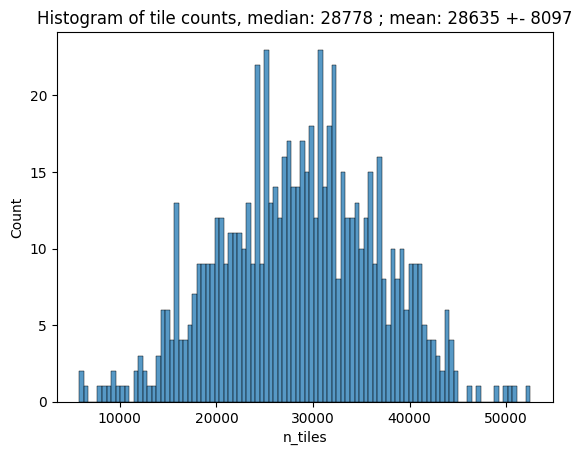

In [19]:
sns.histplot(summ_df["n_tiles"], bins=100)
plt.title(
    "Histogram of tile counts, median: {:.0f} ; mean: {:.0f} +- {:.0f}".format(
        np.median(summ_df["n_tiles"]), np.mean(summ_df["n_tiles"]), np.std(summ_df["n_tiles"])
    )
)
plt.show()

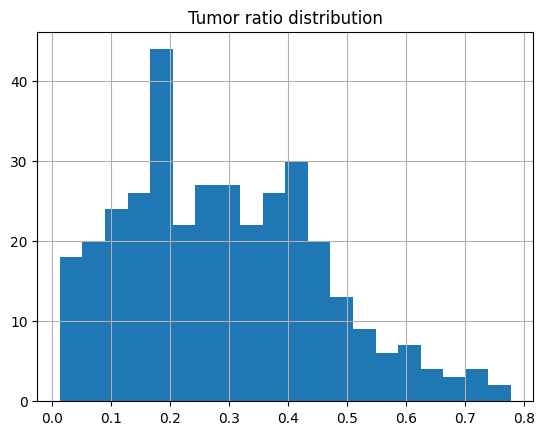

In [20]:
grp = summ_df.groupby(by="patient_ID")
summ_patients = grp.agg(
    {
        "n_tiles": "sum",
        "n_tum_tiles": "sum",
        "non_tum_tiles": "sum",
    }
)
summ_patients["tum_ratio"] = summ_patients["n_tum_tiles"] / summ_patients["n_tiles"]
summ_patients.tum_ratio.hist(bins=20)
plt.title("Tumor ratio distribution")
plt.show()

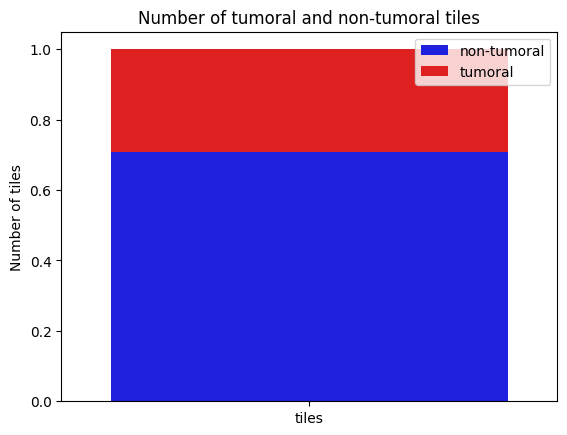

In [21]:
summ_df["non_tum_tiles"] = summ_df["n_tiles"] - summ_df["n_tum_tiles"]
summ_df["tum_ratio"] = summ_df["n_tum_tiles"] / summ_df["n_tiles"]

# # sns stacked barplot
fig, ax = plt.subplots()
sns.barplot(
    x=["tiles"],
    y=summ_df.non_tum_tiles.sum() / summ_df.n_tiles.sum(),
    ax=ax,
    color="blue",
    label="non-tumoral",
)
sns.barplot(
    x=["tiles"],
    y=summ_df.n_tum_tiles.sum() / summ_df.n_tiles.sum(),
    bottom=summ_df.non_tum_tiles.sum() / summ_df.n_tiles.sum(),
    ax=ax,
    color="red",
    label="tumoral",
)
ax.set_ylabel("Number of tiles")
ax.legend()
plt.title("Number of tumoral and non-tumoral tiles")
plt.show()